In [1]:
import sys
try:
    sys.path.remove('/home/adun6414/JModelica/v2_0/JModelica/Python')
    sys.path.append('/home/adun6414/Downloads/PyFMI') # !!!!
except:
    
    print(sys.path)
    
import pyfmi
from pandas import *
from H_utility import *
import numpy as np
from numpy import *
import matplotlib.pyplot as mp
import time
from scipy.linalg import block_diag
import scipy as sp
from H_blkdiag import H_blkdiag
import PnP_subfunc
from PnP_subfunc import H_vec
import scipy as sp
import scipy.interpolate
import control.matlab as ctool
from H_simobj import H_simobj
import os

In [2]:
currentdir='/home/adun6414/Work/CERC_UCM'
os.chdir(currentdir)


# configuration
dt=60*60; # 60 min sampling time
start_time=H_date2simtime(to_datetime('2018-08-01 00:00'),'2018')
final_time=H_date2simtime(to_datetime('2018-08-06 23:45'),'2018')
simtimes=arange(start_time,final_time,dt)
simtimedate=date_range(start=H_simtime2date(start_time,'2018'),end=H_simtime2date(final_time,'2018'),freq=str(int(dt*1./60))+'T')

key_x='H_par_x0'
x0_val=0.6; # initial state of charge
# inputs (controllable variables)
key_u=['ChillerON','SP_mCH', 'TCHeSP']
# inputs: disturbance
key_w=['BuildingCoolingLoads', 'ER', 'PnonHVAC', 'Psolarpv']
# outputs of interests
key_y=['Output[1]','Output[2]','Output[3]','Output[4]','Sensor_TCHWS.T','Sensor_TCHWR.T','Sensor_msup.m_flow','Sensor_mCHi.m_flow','Sensor_mS.m_flow','time',
      'Sensor_Tstorage[1].y','Sensor_Tstorage[2].y','Sensor_Height[1]','Sensor_Height[2]','Sensor_Height[3]']

testcase=2
if testcase==1:
    modelname='Merced.CoolingPlantNew.Chiller_Storage_Only_V2_MPC'
    modelicafile='/home/adun6414/Work/CERC_UCM/Merced/CoolingPlantNew/Chiller_Storage_Only_V2_MPC.mo'
elif testcase==2:
    modelname='Merced.CoolingPlantNew.Chiller_Storage_CoolingTower_V2_MPC'
    modelicafile='/home/adun6414/Work/CERC_UCM/Merced/CoolingPlantNew/Chiller_Storage_CoolingTower_V2_MPC.mo'

idmodel=list() # not used for UC-Merced

#% data loading and resampling
os.chdir('/home/adun6414/Work/CERC_UCM/Fig_n_data')
filename='DATA8to8.csv' #filename='DATA8to9.csv'
DATARAW=read_csv(filename).set_index('Date')
DATARAW=DATARAW.set_index(to_datetime(DATARAW.index)) # change 'str' to datetime obj
DATARAW['time']=H_date2simtime(DATARAW.index,'2018')
dummy=DATARAW.reindex(simtimedate,method='nearest') # resample or reindex
DATA=dummy[['time','QBL','Twb','QCHLsum']].fillna(method='ffill')
DATA['Pow']=dummy[['PCHsum','PCTtot']].sum(axis=1)
del DATARAW, dummy
os.chdir(currentdir)

#% specify disturbances
t_schedule=simtimes

CHON=H_schedule(t_schedule,array([7,19]),1,1)
mEva_flow_nominal=gpm2kgs(3000);#obj.fmuinpy.get('mEva_flow_nominal')
SP_mCH=H_schedule(t_schedule,array([7,19]),0.*mEva_flow_nominal,0.9*mEva_flow_nominal)
TCHeSP=H_schedule(t_schedule,array([7,19]),4,4) # C
QBL=H_iscolumn(DATA['QBL'].to_numpy()) # kW
ER=H_schedule(t_schedule,array([7,19]),2,1) #$/kWh
PnonHVAC=filtfilt(3,H_schedule(t_schedule,[7,19],0*1000,0)) # kW
Psolarpv=filtfilt(3,H_schedule(t_schedule,[7,19],0*1000,0)) # kW
          
u=hstack((CHON,SP_mCH,TCHeSP))
w=hstack((QBL,ER,PnonHVAC,Psolarpv))

schedule={'u': u, 'w': w, 't': H_iscolumn(t_schedule)}
obj=H_simobj(dt=dt,start_time=start_time,final_time=final_time,modelname=modelname,modelicafile=modelicafile,
             fmu='./Merced_CoolingPlantNew_Chiller_Storage_CoolingTower_V2_MPC.fmu',
             idmodel=idmodel,key_u=key_u,key_w=key_w,key_y=key_y,key_x=key_x,schedule=schedule)
   
#(res,IN0)=obj.simulate_schedule(x0_val,schedule,wannaplot=True)
# conventional control simulation
from H_DP_Merced_Simple import *
obj.Ctrlsetup(Convobj=H_Conv_Merced_Simple,MPCobj=H_DP_Merced_Simple,Npday=2)



Could not find GLIMDA.


Final Run Statistics: --- 

 Number of steps                                 : 631
 Number of function evaluations                  : 683
 Number of Jacobian evaluations                  : 13
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 4
 Number of nonlinear iterations                  : 673
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 644
 Number of state events                          : 2

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18316800.0 - 18320400.0 seconds.
Elapsed simulation time: 0.13284639599987713 

Final Run Statistics: --- 

 Number of steps                                 : 1037
 Number of function evaluations                  : 1395
 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 36
 Number of nonlinear iterations                  : 1295
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1250
 Number of state events                          : 24

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18349200.0 - 18352800.0 seconds.
Elapsed simulation time: 0.207311793999

Final Run Statistics: --- 

 Number of steps                                 : 1126
 Number of function evaluations                  : 1497
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1385
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1331
 Number of state events                          : 27

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18381600.0 - 18385200.0 seconds.
Elapsed simulation time: 0.231158542999

Final Run Statistics: --- 

 Number of steps                                 : 502
 Number of function evaluations                  : 507
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 503
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 503

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18414000.0 - 18417600.0 seconds.
Elapsed simulation time: 0.11993208599960781 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 1112
 Number of function evaluations                  : 1478
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1366
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1312
 Number of state events                          : 27

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18446400.0 - 18450000.0 seconds.
Elapsed simulation time: 0.217844288999

Final Run Statistics: --- 

 Number of steps                                 : 506
 Number of function evaluations                  : 512
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 508
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 507

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18478800.0 - 18482400.0 seconds.
Elapsed simulation time: 0.12287896599991655 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 503
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 506
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 504

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18514800.0 - 18518400.0 seconds.
Elapsed simulation time: 0.11859489299968118 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 1127
 Number of function evaluations                  : 1501
 Number of Jacobian evaluations                  : 35
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1385
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1340
 Number of state events                          : 28

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18547200.0 - 18550800.0 seconds.
Elapsed simulation time: 0.230157085999

Final Run Statistics: --- 

 Number of steps                                 : 503
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 504
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 504

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18583200.0 - 18586800.0 seconds.
Elapsed simulation time: 0.11990881500059913 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 1042
 Number of function evaluations                  : 1364
 Number of Jacobian evaluations                  : 31
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 30
 Number of nonlinear iterations                  : 1264
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1216
 Number of state events                          : 24

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18615600.0 - 18619200.0 seconds.
Elapsed simulation time: 0.207557024999

Final Run Statistics: --- 

 Number of steps                                 : 503
 Number of function evaluations                  : 509
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 505
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 504

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18651600.0 - 18655200.0 seconds.
Elapsed simulation time: 0.11971437899956072 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 502
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 504
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 503

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18687600.0 - 18691200.0 seconds.
Elapsed simulation time: 0.1212708240000211 seconds.
Final Run Statistics: --- 

 Number of steps  

Final Run Statistics: --- 

 Number of steps                                 : 1127
 Number of function evaluations                  : 1502
 Number of Jacobian evaluations                  : 35
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1386
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1341
 Number of state events                          : 28

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18720000.0 - 18723600.0 seconds.
Elapsed simulation time: 0.224592440999

Final Run Statistics: --- 

 Number of steps                                 : 500
 Number of function evaluations                  : 504
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 500
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 501

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18752400.0 - 18756000.0 seconds.
Elapsed simulation time: 0.11990986000091652 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 1139
 Number of function evaluations                  : 1514
 Number of Jacobian evaluations                  : 35
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1398
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1351
 Number of state events                          : 28

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18784800.0 - 18788400.0 seconds.
Elapsed simulation time: 0.227063681999

Final Run Statistics: --- 

 Number of steps                                 : 1126
 Number of function evaluations                  : 1495
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 34
 Number of nonlinear iterations                  : 1383
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1330
 Number of state events                          : 27

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18817200.0 - 18820800.0 seconds.
Elapsed simulation time: 0.225311513000

/home/adun6414/Downloads/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


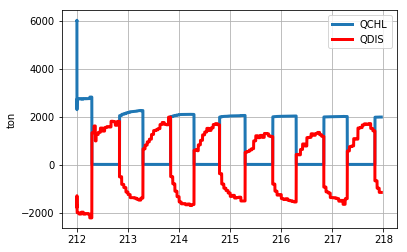

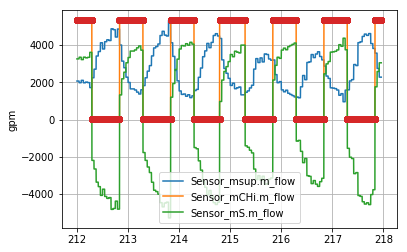

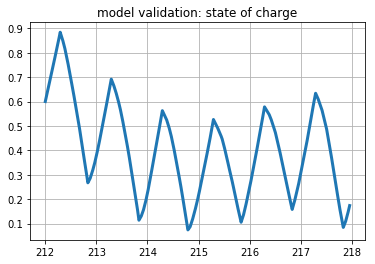

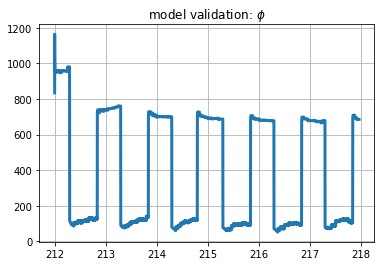

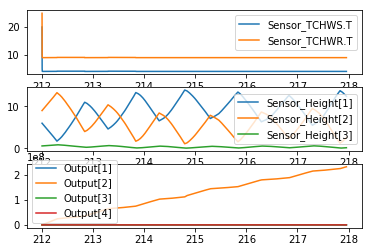

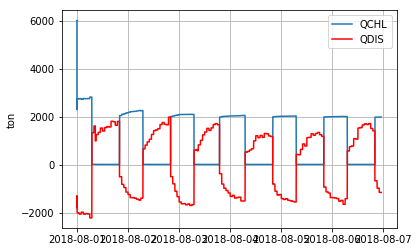

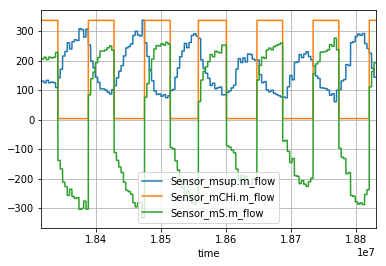

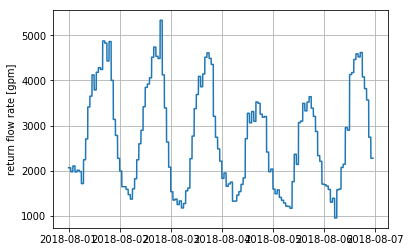

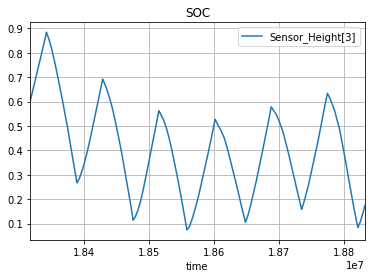

In [3]:
obj.evaluate_Ctrl(x0_val,control='Conv')
res=obj.analysis_performance(control='Conv')
data=DataFrame(columns=obj.key_u+obj.key_y+obj.key_w)  
for k in obj.key_u+obj.key_y+obj.key_w:
    data[k]=res[k]
data.index=data.time
figure(100)
plot(to_datetime(H_simtime2date(data['time'],'2018')),kW2ton(data['Output[3]']))     
plot(to_datetime(H_simtime2date(data['time'],'2018')),kW2ton(data['Output[4]']),'r')
legend(['QCHL','QDIS'])
ylabel('ton')
grid(True)

data.plot(x='time',y=[k for k in obj.key_y if '.m_flow' in k])
grid(True)

figure(102)
plot(to_datetime(H_simtime2date(data['time'],'2018')),data['Sensor_msup.m_flow'].apply(kgs2gpm))
ylabel('return flow rate [gpm]')
grid(True)

data.plot(x='time',y=[k for k in obj.key_y if 'Height[3]' in k])    
title('SOC')
grid(True)


In Bellam,  Np: 48 W: (48, 4)
(48, 1)
Final Run Statistics: --- e+07

 Number of steps                                 : 87507
 Number of function evaluations                  : 135787
 Number of Jacobian evaluations                  : 2969
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 6101
 Number of nonlinear iterations                  : 124177
 Number of nonlinear convergence failures        : 2
 Number of state function evaluations            : 109391
 Number of state events                          : 2902

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18316800.0 - 1848

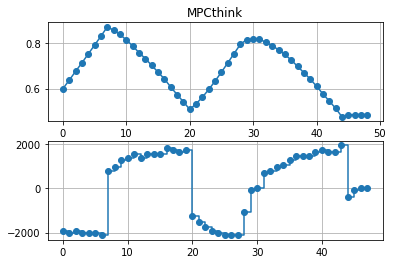

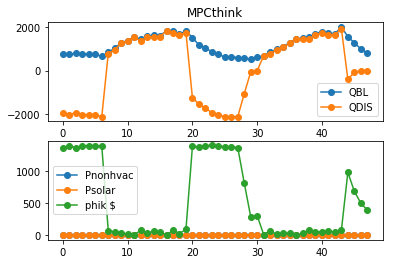

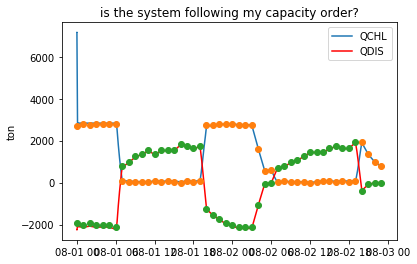

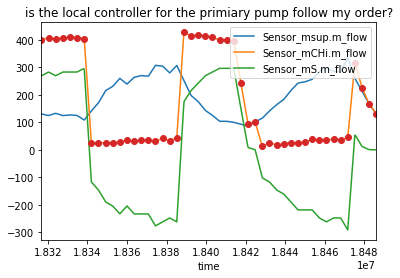

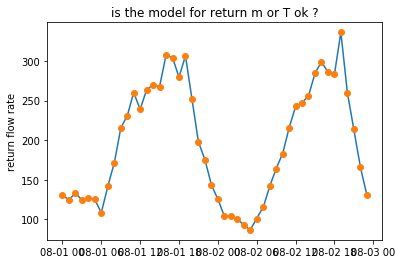

<Figure size 432x288 with 0 Axes>

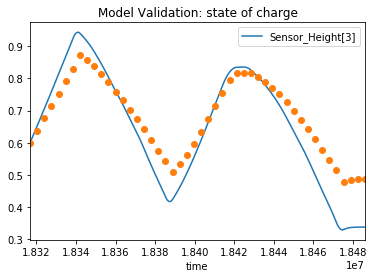

<Figure size 432x288 with 0 Axes>

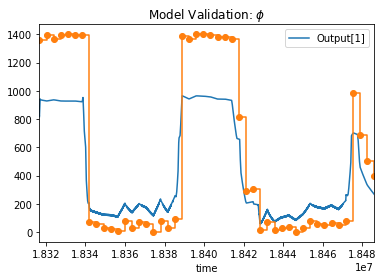

In [4]:
#%% MPC evaulation inputs: starts, final time, IC
obj.does_local_follow_mpc(x0_val)
    

In [5]:
#%% MPC evaulation inputs: starts, final time, IC
obj.evaluate_Ctrl(x0_val,control='MPC')

Np adjusted: 48
In Bellam,  Np: 48 W: (48, 4)
        cur_t          Uop         x          phi
0  18316800.0 -6791.272592  0.600000  1361.605645
1  18316800.0 -7130.818637  0.637223  1393.147414
2  18316800.0 -6791.272592  0.676306  1368.928145
u*: [  1.         399.96955947   4.14498283]
x: 0.6
Final Run Statistics: --- 

 Number of steps                                 : 628
 Number of function evaluations                  : 674
 Number of Jacobian evaluations                  : 13
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 2
 Number of nonlinear iterations                  : 664
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 641
 Number of state events                          : 2

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tole

        cur_t          Uop         x        phi
0  18342000.0  2716.720048  0.885766  73.464958
1  18342000.0  3395.812139  0.870875  53.739124
2  18342000.0  4414.450275  0.852263  30.540980
u*: [ 1.         25.18092177  7.01320707]
x: [[0.88576559]]
Final Run Statistics: --- 

 Number of steps                                 : 1940
 Number of function evaluations                  : 2810
 Number of Jacobian evaluations                  : 59
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 94
 Number of nonlinear iterations                  : 2586
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 2363
 Number of state events                          : 55

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.

        cur_t          Uop         x        phi
0  18367200.0  5433.088411  0.631586  69.074216
1  18367200.0  5433.088411  0.601808  53.686719
2  18367200.0  6451.726547  0.572029   1.379139
u*: [ 1.         37.38421886  7.90470794]
x: [[0.63158598]]
Final Run Statistics: --- 

 Number of steps                                 : 2640
 Number of function evaluations                  : 4080
 Number of Jacobian evaluations                  : 74
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 204
 Number of nonlinear iterations                  : 3784
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 3198
 Number of state events                          : 73

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1

        cur_t          Uop         x          phi
0  18392400.0 -5433.088411  0.374722  1369.830319
1  18392400.0 -6112.180501  0.404501  1399.700401
2  18392400.0 -6791.272592  0.438001  1400.803902
u*: [  1.         413.49035697   4.21270587]
x: [[0.37472243]]
Final Run Statistics: --- 

 Number of steps                                 : 511
 Number of function evaluations                  : 520
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 516
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 512

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.

        cur_t          Uop         x          phi
0  18417600.0 -7809.910728  0.739378  1394.533165
1  18417600.0 -7809.910728  0.782183  1375.527298
2  18417600.0 -7470.364683  0.824989  1370.022423
u*: [  1.         402.86096971   4.10253758]
x: [[0.73937762]]
Final Run Statistics: --- 

 Number of steps                                 : 508
 Number of function evaluations                  : 515
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 511
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 509

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.

        cur_t          Uop         x        phi
0  18442800.0  4414.450275  0.804545  32.470050
1  18442800.0  5093.542365  0.780350   0.694119
2  18442800.0  5093.542365  0.752432  28.672360
u*: [ 1.         26.43286671  8.42078042]
x: [[0.80454498]]
Final Run Statistics: --- 

 Number of steps                                 : 3855
 Number of function evaluations                  : 6027
 Number of Jacobian evaluations                  : 127
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 310
 Number of nonlinear iterations                  : 5519
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 4819
 Number of state events                          : 126

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01

        cur_t          Uop         x          phi
0  18468000.0  5772.634456  0.497299    48.831218
1  18468000.0  6791.272592  0.465660    78.111008
2  18468000.0 -4074.904229  0.428437  1362.573290
u*: [ 1.         35.62727178  8.30226658]
x: [[0.49729914]]
Final Run Statistics: --- 

 Number of steps                                 : 4330
 Number of function evaluations                  : 6793
 Number of Jacobian evaluations                  : 146
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 340
 Number of nonlinear iterations                  : 6209
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 5410
 Number of state events                          : 145

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-0

        cur_t          Uop         x          phi
0  18493200.0 -7809.910728  0.621542  1371.489881
1  18493200.0 -7809.910728  0.664347  1375.441024
2  18493200.0 -8149.456773  0.707153  1401.368950
u*: [  1.         395.17987518   4.09589195]
x: [[0.62154174]]
Final Run Statistics: --- 

 Number of steps                                 : 510
 Number of function evaluations                  : 519
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 515
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 511

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.

        cur_t          Uop         x        phi
0  18518400.0  2037.627957  0.857578  30.615825
1  18518400.0  2716.720048  0.846410  82.438575
2  18518400.0  3395.812139  0.831519  77.608938
u*: [ 1.         14.80562785  7.72123566]
x: [[0.85757771]]
Final Run Statistics: --- 

 Number of steps                                 : 2575
 Number of function evaluations                  : 4007
 Number of Jacobian evaluations                  : 93
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 189
 Number of nonlinear iterations                  : 3663
 Number of nonlinear convergence failures        : 3
 Number of state function evaluations            : 3257
 Number of state events                          : 85

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1

        cur_t          Uop         x        phi
0  18543600.0  5433.088411  0.631328  15.674793
1  18543600.0  5772.634456  0.601549  59.195569
2  18543600.0  5772.634456  0.569910  96.057504
u*: [ 1.         28.48431509  8.98586478]
x: [[0.6313277]]
Final Run Statistics: --- 

 Number of steps                                 : 3856
 Number of function evaluations                  : 5985
 Number of Jacobian evaluations                  : 159
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 283
 Number of nonlinear iterations                  : 5473
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 4842
 Number of state events                          : 127

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 

        cur_t          Uop         x          phi
0  18568800.0 -6451.726547  0.487429  1391.887093
1  18568800.0 -6791.272592  0.522791  1389.008176
2  18568800.0 -7130.818637  0.560013  1365.505840
u*: [  1.         412.75818531   4.16876956]
x: [[0.48742943]]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 512
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 508
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.

        cur_t          Uop         x         phi
0  18594000.0    62.201027  0.763079  242.324049
1  18594000.0    41.215554  0.762739  245.761919
2  18594000.0  1698.081912  0.762513   68.351803
u*: [ 1.         81.07087852  4.46271212]
x: [[0.76307945]]
Final Run Statistics: --- 

 Number of steps                                 : 503
 Number of function evaluations                  : 509
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 505
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 504

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1

        cur_t          Uop         x        phi
0  18619200.0  4074.904229  0.667340  74.600042
1  18619200.0  3735.358184  0.645006  91.665575
2  18619200.0  4074.904229  0.624533  89.098739
u*: [ 1.         31.83764618  7.49182831]
x: [[0.66734013]]
Final Run Statistics: --- 

 Number of steps                                 : 3685
 Number of function evaluations                  : 5645
 Number of Jacobian evaluations                  : 123
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 242
 Number of nonlinear iterations                  : 5153
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 4612
 Number of state events                          : 122

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01

        cur_t          Uop         x          phi
0  18644400.0  4074.904229  0.429918    41.928211
1  18644400.0 -5433.088411  0.407584  1382.006600
2  18644400.0 -6451.726547  0.437362  1378.637568
u*: [ 1.         26.39234098  8.12056887]
x: [[0.42991828]]
Final Run Statistics: --- 

 Number of steps                                 : 3703
 Number of function evaluations                  : 5781
 Number of Jacobian evaluations                  : 124
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 278
 Number of nonlinear iterations                  : 5285
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 4592
 Number of state events                          : 123

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-0

        cur_t          Uop         x          phi
0  18669600.0 -7470.364683  0.711917  1365.638621
1  18669600.0 -7809.910728  0.752862  1382.812664
2  18669600.0 -7809.910728  0.795667  1370.768333
u*: [  1.         395.92426505   4.11167256]
x: [[0.71191697]]
Final Run Statistics: --- 

 Number of steps                                 : 509
 Number of function evaluations                  : 516
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 512
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 510

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.

        cur_t          Uop         x        phi
0  18694800.0  2037.627957  0.851838  83.888740
1  18694800.0  3056.266093  0.840669  22.455521
2  18694800.0  2716.720048  0.823918  34.323339
u*: [ 1.         23.68444697  6.49283305]
x: [[0.85183755]]
Final Run Statistics: --- 

 Number of steps                                 : 3130
 Number of function evaluations                  : 4579
 Number of Jacobian evaluations                  : 100
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 149
 Number of nonlinear iterations                  : 4179
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 3851
 Number of state events                          : 99

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 

        cur_t          Uop         x        phi
0  18720000.0  4414.450275  0.653517  71.375166
1  18720000.0  4753.996320  0.629322  19.624377
2  18720000.0  4414.450275  0.603265  20.326582
u*: [ 1.         32.91705271  7.63749942]
x: [[0.65351714]]
Final Run Statistics: --- 

 Number of steps                                 : 3677
 Number of function evaluations                  : 5632
 Number of Jacobian evaluations                  : 127
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 212
 Number of nonlinear iterations                  : 5124
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 4670
 Number of state events                          : 126

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01

        cur_t          Uop         x          phi
0  18745200.0 -7470.364683  0.653100  1389.976671
1  18745200.0 -7470.364683  0.694044  1387.161397
2  18745200.0 -7420.517627  0.734989  1374.468676
u*: [  1.         404.03694826   4.11835431]
x: [[0.65309983]]
Final Run Statistics: --- 

 Number of steps                                 : 508
 Number of function evaluations                  : 514
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 510
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 509

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.

        cur_t          Uop         x         phi
0  18770400.0   -66.361656  0.678708  308.420126
1  18770400.0  2037.627957  0.679072   21.958590
2  18770400.0  2716.720048  0.667904    8.992478
u*: [  1.         102.28002896   4.43300135]
x: [[0.67870825]]
Final Run Statistics: --- 

 Number of steps                                 : 505
 Number of function evaluations                  : 511
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 506

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01

        cur_t          Uop         x        phi
0  18795600.0  5433.088411  0.511619  28.024685
1  18795600.0  5772.634456  0.481840  40.400987
2  18795600.0  5772.634456  0.450201  87.642321
u*: [ 1.         30.54263044  8.67981141]
x: [[0.51161872]]
Final Run Statistics: --- 

 Number of steps                                 : 4080
 Number of function evaluations                  : 6363
 Number of Jacobian evaluations                  : 139
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 297
 Number of nonlinear iterations                  : 5811
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 5065
 Number of state events                          : 137

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01

        cur_t          Uop         x          phi
0  18820800.0   815.317623  0.193201   558.623521
1  18820800.0 -6112.180501  0.188732  1392.497413
2  18820800.0 -6791.272592  0.222233  1401.295836
u*: [  1.         190.09030521   4.54656604]
x: [[0.19320104]]
Final Run Statistics: --- 

 Number of steps                                 : 520
 Number of function evaluations                  : 530
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 526
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 521

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.

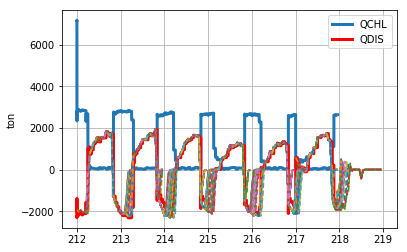

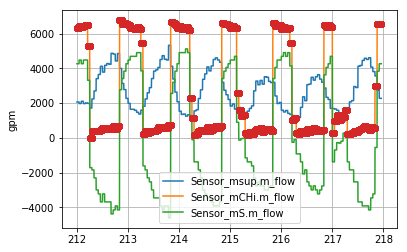

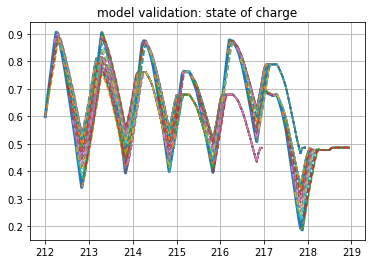

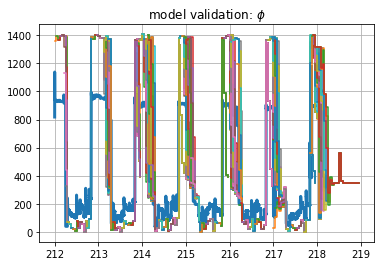

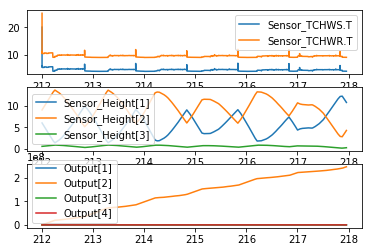

In [6]:
obj.analysis_performance(control='MPC')
obj.fmuinpy.print_log()